**目录**<a id='toc0_'></a>    
- [空间数据分析之空间自相关](#toc1_)    
  - [柏林房价分析](#toc1_1_)    
    - [1 数据处理](#toc1_1_1_)    
    - [2 空间自相关](#toc1_1_2_)    
    - [3 局部空间自相关](#toc1_1_3_)   
    - [4 结论](#toc1_1_4_) 

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_1_'></a>[1 数据处理](#toc0_)

数据集来自 2018 年 4 月拍摄的柏林 Airbnb 抓取数据。包括柏林的矢量数据和房价数据，通过geopandas获得柏林每个社区的房价的中位数。分析柏林房价是否存在空间相关性。

In [1]:
#加载项目所需要的库
import esda
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import libpysal as lps
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from shapely.geometry import Point

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams['font.sans-serif'] = ['SimHei'] 

**加载柏林矢量数据并显示,查看坐标系**

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

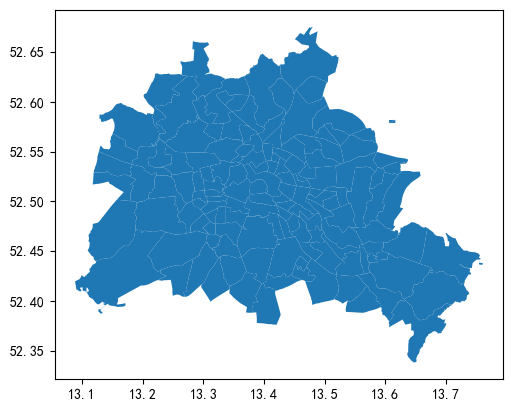

In [4]:
gdf = gpd.read_file('data/berlin-neighbourhoods.geojson')
gdf.plot()
gdf.crs

**读取柏林房价数据，通过zip函数将数据中的经纬度组合起来，设置为geometry字段
设置坐标系，转换为geoDataFrame格式**

In [5]:
bl_df = pd.read_csv('data/berlin-listings.csv')
geometry = [Point(xy) for xy in zip(bl_df.longitude, bl_df.latitude)]
crs = {'init': 'epsg:4326'}
bl_gdf = GeoDataFrame(bl_df, crs=crs, geometry=geometry)

**通过sjoin函数合并柏林矢量数据和房价数据，方式为inner内连接，op为intersects交集
通过neighbourhood_group对交集后的数据进行分组，然后计算每个分组房价的平均值**

In [6]:
bl_gdf['price'] = bl_gdf['price'].astype('float32')
sj_gdf = gpd.sjoin(gdf, bl_gdf, how='inner', op='intersects', lsuffix='left', rsuffix='right')
median_price_gb = sj_gdf['price'].groupby([sj_gdf['neighbourhood_group']]).mean()
median_price_gb

neighbourhood_group
Charlottenburg-Wilm.        58.556408
Friedrichshain-Kreuzberg    55.492809
Lichtenberg                 44.584270
Marzahn - Hellersdorf       54.246754
Mitte                       60.387890
Neukölln                    45.135948
Pankow                      60.282516
Reinickendorf               43.682465
Spandau                     48.236561
Steglitz - Zehlendorf       54.445683
Tempelhof - Schöneberg      53.704407
Treptow - Köpenick          51.222004
Name: price, dtype: float32

**将计算的各分区平均房价加入到柏林矢量数据中**

In [7]:
gdf = gdf.join(median_price_gb, on='neighbourhood_group')
gdf.rename(columns={'price': 'median_pri'}, inplace=True)
gdf.head(20)

,neighbourhood,neighbourhood_group,geometry,median_pri
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52...",60.282516
1,Helmholtzplatz,Pankow,"MULTIPOLYGON (((13.41405 52.54929, 13.41422 52...",60.282516
2,Wiesbadener Straße,Charlottenburg-Wilm.,"MULTIPOLYGON (((13.30748 52.46788, 13.30743 52...",58.556408
3,Schmöckwitz/Karolinenhof/Rauchfangswerder,Treptow - Köpenick,"MULTIPOLYGON (((13.70973 52.39630, 13.70926 52...",51.222004
4,Müggelheim,Treptow - Köpenick,"MULTIPOLYGON (((13.73762 52.40850, 13.73773 52...",51.222004
5,Biesdorf,Marzahn - Hellersdorf,"MULTIPOLYGON (((13.56643 52.53510, 13.56697 52...",54.246754
6,Nord 1,Reinickendorf,"MULTIPOLYGON (((13.33669 52.62265, 13.33663 52...",43.682465
7,West 5,Reinickendorf,"MULTIPOLYGON (((13.28138 52.59958, 13.28158 52...",43.682465
8,Frankfurter Allee Nord,Friedrichshain-Kreuzberg,"MULTIPOLYGON (((13.45320 52.51682, 13.45321 52...",55.492809
9,Buch,Pankow,"MULTIPOLYGON (((13.46449 52.65055, 13.46457 52...",60.282516


**统计gdf中各个区平均房价中缺失值的数量
并计算平均值，赋给缺失值**

In [8]:
pd.isnull(gdf['median_pri']).sum()
gdf['median_pri'].fillna((gdf['median_pri'].mean()), inplace=True)

**绘图展示柏林各区域的平均房价**

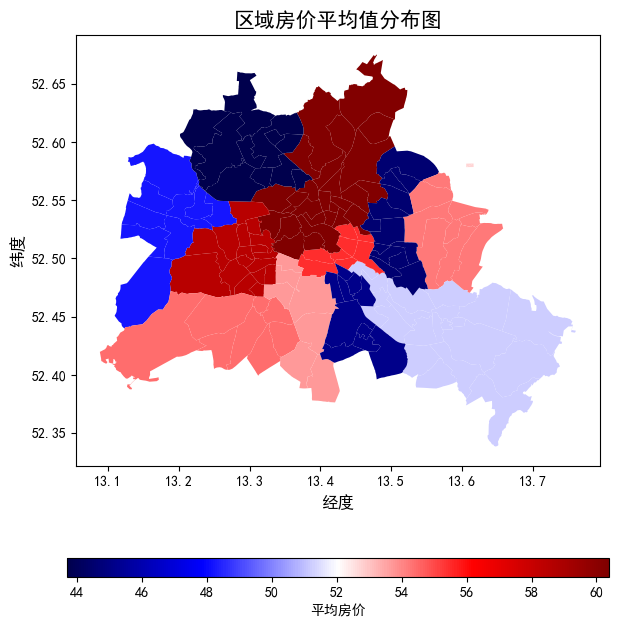

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# 绘制GeoDataFrame
gdf.plot(column='median_pri', ax=ax, legend=True, cmap='seismic',
         legend_kwds={'label': "平均房价", 
                      'orientation': "horizontal",
                      'shrink': 0.7,  
                      'aspect': 30, 
                      'pad': 0.15})  

ax.set_title("区域房价平均值分布图", fontsize=15)
ax.set_xlabel("经度", fontsize=12)
ax.set_ylabel("纬度", fontsize=12)

plt.show()

### <a id='toc1_1_2_'></a>[2 空间自相关](#toc0_)

**全局空间自相关主要用于描述区域单元某种现象的整体空间分布情况，以判断该现象在空间上是否存在聚集性。**

全局莫兰指数：
$$
\mathrm{Moran's}I=\frac{\sum_{i=1}^{n}\sum_{j=1}^{n}w_{ij}(x_{i}-\overline{x})(x_{j}-\overline{x})}{S^{2}\sum_{i=1}^{n}\sum_{j=1}^{n}w_{ij}}
$$

其中方差为$S^{2}=\frac{1}{n}\sum_{i=1}^{n}(x_{i}-\overline{x})^{2}$，$\overline{x}=\frac{1}{n}\sum_{i=1}^{n}x_{i}$， $x_{i}为第{i}地区的观测值；n为地区总数；w_{ij}为空间权重矩阵中第i行第j列的一个元素，以度量区域i与区域j之间的距离；\sum_{i=1}^n\sum_{j=1}^nw_{ij}为所有空间权重之和$，$如果空间权重为行标准化，则\sum_{i=1}^n\sum_{j=1}^nw_{ij}为n$


$$
Z_{\alpha}=\frac{I-E(I)}{\sqrt{\mathrm{Var}(I)}}
$$
利用Z值计算事物是否具有空间相关性

**通过房价分布图，我们可以粗略的发现柏林房价在中北部较高，东南处较低，接下来通过定量度量柏林房价的空间自相关**
**根据地理学第一定律，越近越相似，我们需要计算各个区彼此之间的距离，即空间权重矩阵**
**创建空间权重矩阵并进行标准化**



In [10]:
df = gdf
wq =  lps.weights.Queen.from_dataframe(df)
wq.transform = 'r'

**一个地区的房价还受到它周围地区房价的影响，计算空间滞后，即属性相似度**

In [11]:
y = df['median_pri']
ylag = lps.weights.lag_spatial(wq, y)

**计算柏林所有区域房价均值，并绘图，高于平均房价为黑色，反之为白色**

In [12]:
yb = y > y.median()
labels = ["0 Low", "1 High"]
yb = [labels[i] for i in 1*yb]
df['yb'] = yb

<Axes: >

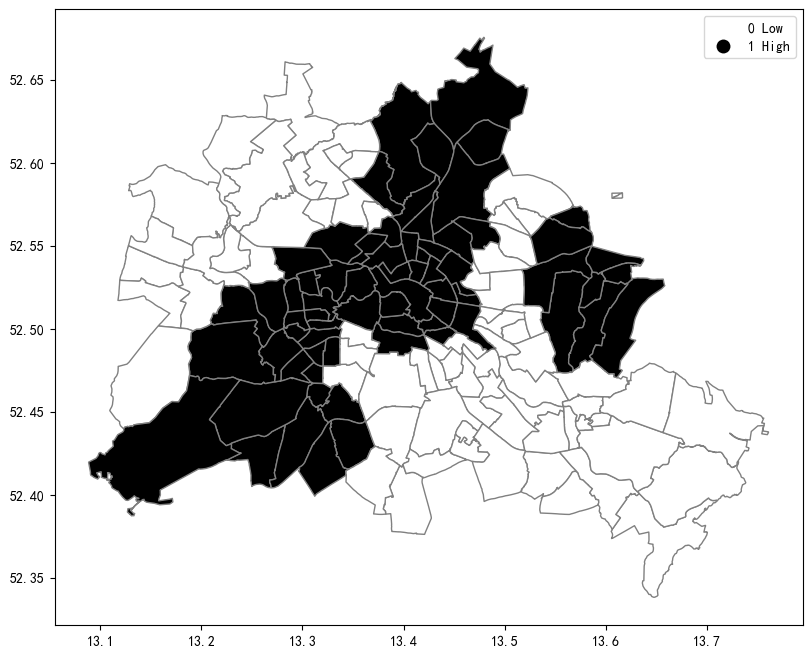

In [13]:
fig, ax = plt.subplots(figsize=(10,8), subplot_kw={'aspect':'equal'})
df.plot(column='yb', cmap='binary', edgecolor='grey', legend=True, ax=ax)

**使用esda库中的Join_Counts方法对空间数据进行探索性分析，将数据转换为二元形式，高于均值为1，低于为0，**

**基于Queen标准的空间权重矩阵wq并将其转换为二元形式。最后，使用esda.join_counts.Join_Counts来计算相邻地理单元间相同值（1或0）出现的次数。**
**可以识别空间聚类现象，高值或低值是否倾向于在空间上聚集**

queen和rook,bishop的空间相邻的区别

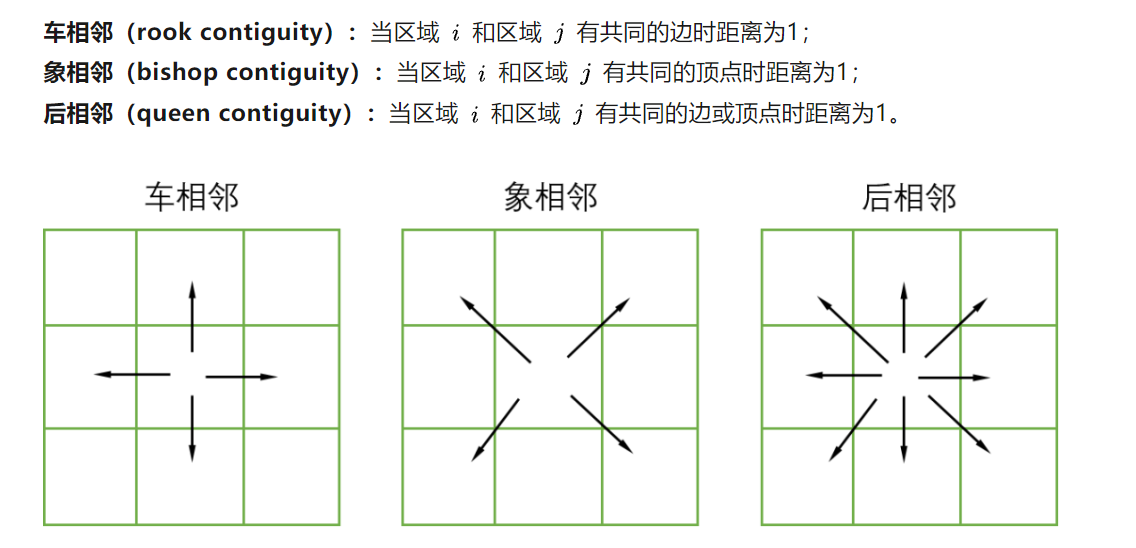

In [14]:
y = df['median_pri'] 
yb = 1 * (y > y.median())
wq = lps.weights.Queen.from_dataframe(df)
wq.transform = 'b'
np.random.seed(12345)
jc = esda.join_counts.Join_Counts(yb, wq)
print(f"BB (Both Binary 1): {jc.bb}")
print(f"WW (Both Binary 0): {jc.ww}")
print(f"BW (One of Each): {jc.bw}")
print("jc.meanbb:",jc.mean_bb)

BB (Both Binary 1): 164.0
WW (Both Binary 0): 149.0
BW (One of Each): 73.0
jc.meanbb: 90.70170170170171


**从结果我们发现，jc.bb明显高于jc.mean_bb,jc.mean_bb是基于CSR（完全空间随机）得到的结果，但要判断这种差异是否显著，是否可以判定我们的房价是空间相关的而不是随机的,我们需要查看p值**

p值 0.001


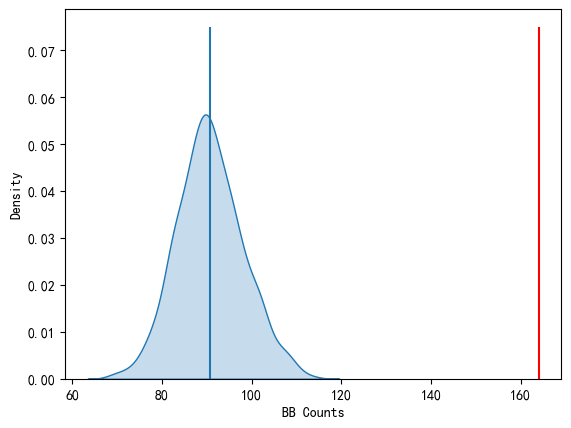

In [15]:
import seaborn as sbn
sbn.kdeplot(jc.sim_bb, shade=True)
plt.vlines(jc.bb, 0, 0.075, color='r')
plt.vlines(jc.mean_bb, 0,0.075)
plt.xlabel('BB Counts')

print("p值",jc.p_sim_bb)

**p值为0.001，我们可以判定，柏林的房价存在空间相关性，拒绝了空间随机性的假设**

**为了判断柏林房价是否存在空间相关性，我们采用了二元变量分析的方法，确定其存在空间相关性，为了衡量空间相关性的强弱，我们需要进行全局莫兰指数和局部莫兰指数的计算，首先我们就要将刚才的空间权重矩阵变化为标准形式**

In [16]:
wq.transform = 'r'
y = df['median_pri']
np.random.seed(12345)
mi = esda.moran.Moran(y, wq)
mi.I

0.6563069331329718

**绘图展示空间数据的自相关性。莫兰指数的实际值与模拟值（基于假定的随机分布CSR）的比较，可以帮助我们理解观察到的空间模式是否显著。计算出的P值为0.001，通过检验**

P值 0.001


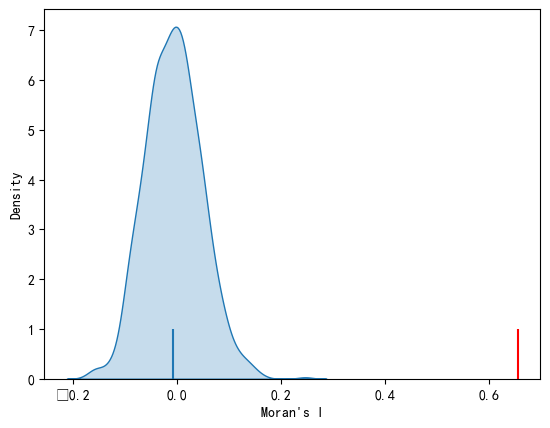

In [17]:
import seaborn as sbn
sbn.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")
print("P值",mi.p_sim)

### <a id='toc1_1_3_'></a>[3 局部空间自相关](#toc0_)

局部空间自相关就是通过计算每一个空间单元与邻近单元就某一属性的相关程度，对各局部区域中的属性信息进行分析，探究整个区域上同一属性的变化是否平滑(均质)或者存在突变(异质)。

局部莫兰指数:
$$
I_{i}=\frac{(x_{i}-\overline{x})}{S^{2}}\sum_{j}w_{ij}(x_{j}-\overline{x})
$$

其中：
$$
S^{2}=\frac{1}{n}\sum_{i=1}^{n}(x_{i}-\overline{x})^{2}\quad\overline{x}=\frac{1}{n}\sum_{i=1}^{n}x_{i}
$$

正的Ⅰ表示该空间单元与邻近单元的观测属性呈现正相关(高值集聚或者低值集聚)，表示一个高值被高值所包围(高-高)或是一个低值被低值所包围(低-低);负的I表示一个高值被低值所包围(高-低)或是一个低值被高值所包围(低-高)。

In [18]:
np.random.seed(12345)
wq.transform = 'r'
lag_price = lps.weights.lag_spatial(wq, df['median_pri'])

创建莫兰散点图，将实际房价展示在散点图上，红色的斜线为空间滞后值，我们发现大部分点呈现高高聚集，低低聚集，少部分点呈现高低聚集，极少部分点呈现低高聚集

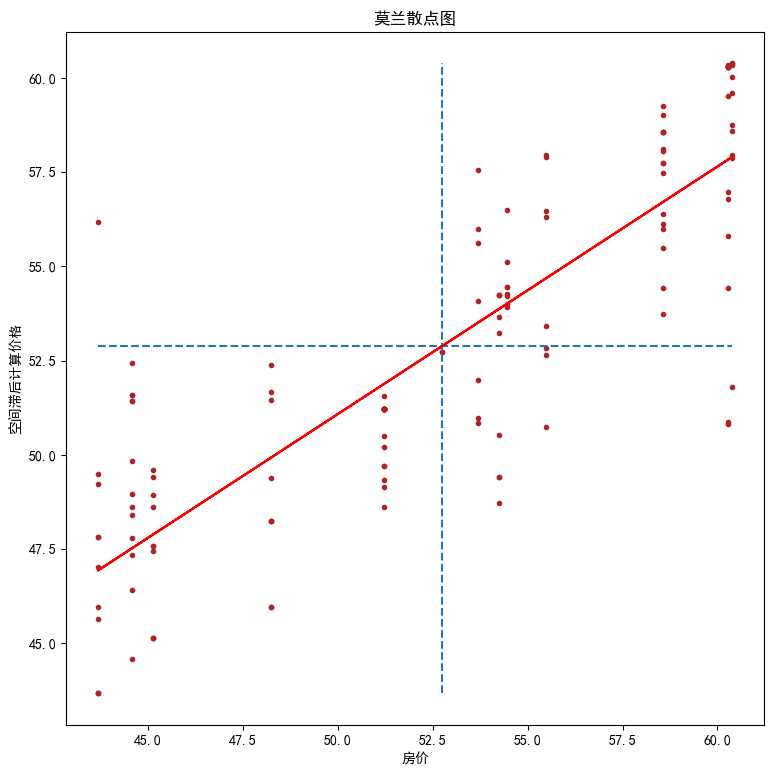

In [19]:
price = df['median_pri']
b, a = np.polyfit(price, lag_price, 1)
f, ax = plt.subplots(1, figsize=(9, 9))
plt.plot(price, lag_price, '.', color='firebrick')
plt.vlines(price.mean(), lag_price.min(), lag_price.max(), linestyle='--')
plt.hlines(lag_price.mean(), price.min(), price.max(), linestyle='--')
plt.plot(price, a + b*price, 'r')
plt.title('莫兰散点图')
plt.ylabel('空间滞后计算价格')
plt.xlabel('房价')
plt.show()

创建空间权重矩阵，并标准化

In [20]:
wq = lps.weights.Queen.from_dataframe(df)
wq.transform = 'r'

利用esda.Moran_Local计算局部莫兰指数，li.q属性提供了每个观测值的象限位置信息。在局部莫兰指数的上下文中，象限表示了空间数据分布的特定类型的局部空间关联。这些象限基于莫兰散点图，反映了每个地理单元与其邻居的关系特征，可以用于识别热点、冷点和空间异常值。象限分为四种类型：

**第一象限（HH）：表示高-高关联，意味着具有高值的观测值周围也是高值。这通常被视为热点。**

**第二象限（LH）：表示低-高关联，意味着具有低值的观测值周围是高值。这可以被看作是空间异常值。**

**第三象限（LL）：表示低-低关联，意味着具有低值的观测值周围也是低值。这通常被视为冷点。**

**第四象限（HL）：表示高-低关联，意味着具有高值的观测值周围是低值。这也可以被看作是空间异常值。**

In [21]:
li = esda.Moran_Local(y, wq)
li.q

array([1, 1, 1, 3, 3, 4, 3, 3, 4, 1, 1, 3, 3, 1, 3, 1, 1, 1, 1, 1, 4, 1,
       1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 3, 1, 1, 4, 1, 1, 1, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 3, 4, 3, 1,
       1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 4, 3, 4, 1, 3, 3, 3, 3, 3, 4, 3, 3,
       4, 1, 1, 1, 1, 2, 3, 3])

统计每个观测值的p值，小于0.05通过检验

In [22]:
(li.p_sim < 0.05).sum()

68

计算出热点、冷点、空间异常值的数量

In [23]:
sig = li.p_sim < 0.05
hotspot = sig * li.q==1
coldspot = sig * li.q==3
doughnut = sig * li.q==2
diamond = sig * li.q==4

In [24]:
spots = ['n.sig.', 'hot spot']
labels = [spots[i] for i in hotspot*1]

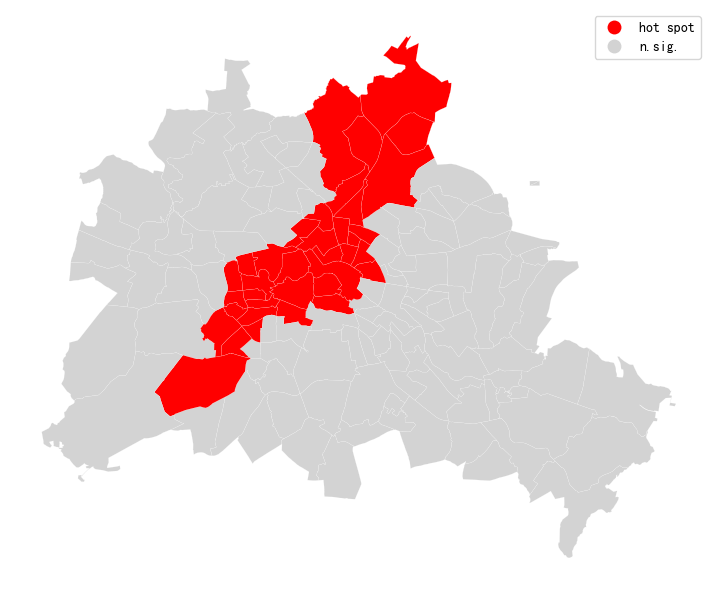

In [25]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [26]:
spots = ['n.sig.', 'cold spot']
labels = [spots[i] for i in coldspot*1]

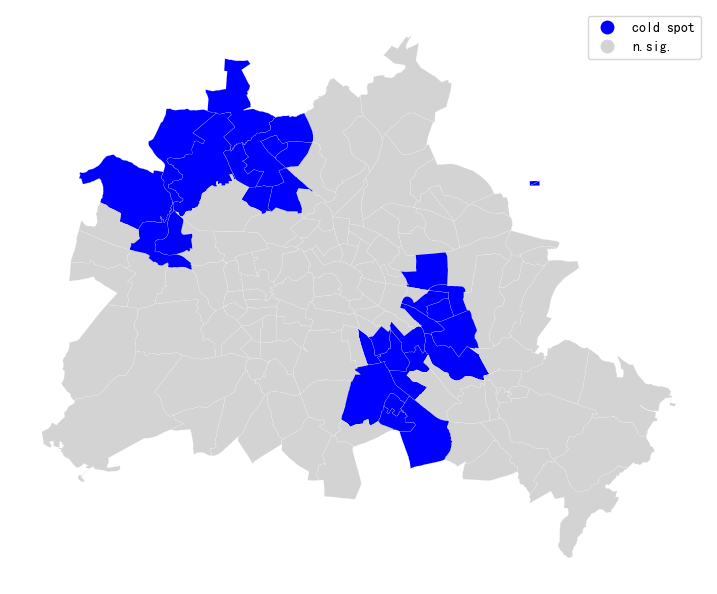

In [27]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['blue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [28]:
sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond
spots

array([1, 1, 0, 0, 0, 0, 3, 3, 0, 1, 0, 3, 3, 0, 3, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 3, 0,
       3, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 3, 0,
       0, 3, 0, 3, 3, 3, 3, 3, 3, 1, 0, 1, 3, 3, 1, 1, 1, 3, 0, 0, 3, 0,
       1, 1, 1, 1, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 3, 3, 3, 0, 0, 0,
       4, 0, 0, 0, 0, 0, 3, 3])

得到柏林市LISA聚集图如下

In [29]:
spot_labels = [ '0 不显著', '1 高-高(HH)', '2 低-高(LH)', '3 低-低(LL)', '4 高-低(HL)']
labels = [spot_labels[i] for i in spots]

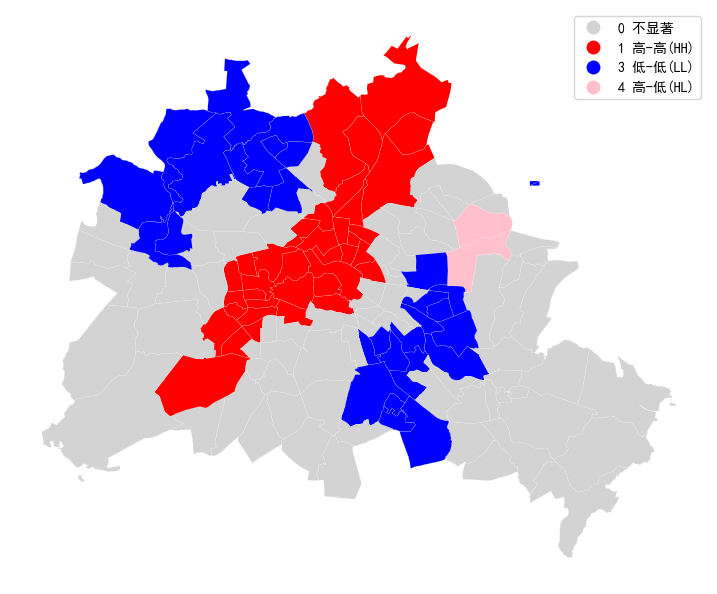

In [30]:
from matplotlib import colors
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

### <a id='toc1_1_4_'></a>[4  结论](#toc0_)

本实验首先对柏林市房价进行分区统计计算各区的平均房价，计算各区域的空间滞后房价（完全空间随机模式 CSR），进行对比，统计实际房价高于平均房价的数量，高于，值记为1；低于，值记为0，利用esda库中的Join_Counts方法对空间数据进行探索性分析，并将空间权重矩阵转为二元形式，得到莫兰指数值为0.656，且P值<0.001，通过检验，说明柏林市房价存在较强的正空间自相关

其次，进行了局部莫兰指数的计算，将真实房价值与空间滞后值绘制为莫兰散点图，统计HH，HL，LH，LL四个象限房价，制得LISA图，发现：柏林市中北部房价呈现出高高的空间聚集类型，柏林市西北部和东南部出现低低的空间聚集类型，东北部少部分出现高低的空间聚集类型。